In [1]:
import numpy as np
from theano import config

a = 5 
b = 2
N = 2000
s_noise = 0.02

x0 = np.linspace(-3.0, 3.0, num=N);
x1 = np.sin(b * x0)
x2 = np.cos(a * x0)

fx = 0.1 * x2 + 0.1 *x1 + 0.4

fx_str = '$f(x)=cos({%g x}) + sin({%g x})$' % (a, b)

nu = np.random.randn(N,) * s_noise
nu[np.random.rand(N,) > 0.95] += 0.2

z = fx + nu

n_train = int(N * 0.5)
i_test = N - n_train

X = np.array([x0, x1, x2]).T

# X = (X - np.mean(X, axis=0)) / np.var(X, axis=0)

y_train = z[0:n_train][:,np.newaxis]
y_test = z[i_test:N][:,np.newaxis]
X_train = X[0:n_train]
X_test = X[i_test:N]

fx_train = fx[0:n_train][:,np.newaxis]
fx_test = fx[i_test:N][:,np.newaxis]

SNR = np.mean(z) / np.std(z)

print('SNR: %g' % SNR)

SNR: 3.69589


<IPython.core.display.Javascript object>


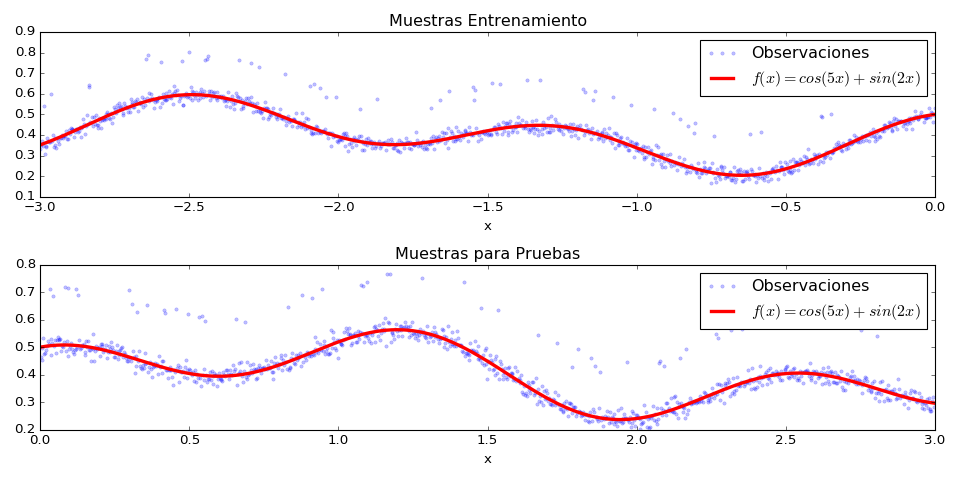

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=80)
ax = plt.subplot(211)
ax.plot(X_train[:,0], y_train, 'b.', alpha=0.25, label='Observaciones')
ax.plot(X_train[:,0], fx_train, '-r', lw=3, label=fx_str)
plt.title('Muestras Entrenamiento')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()

ax = plt.subplot(212)
ax.plot(X_test[:,0], y_test, 'b.', alpha=0.25, label='Observaciones')
ax.plot(X_test[:,0], fx_test, '-r', lw=3, label=fx_str)
plt.title('Muestras para Pruebas')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.tight_layout()

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../../'))

from deepensemble.utils.utils_functions import ActivationFunctions
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.layers.recurrent import RecurrentLayer
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *
from deepensemble.metrics import *
from deepensemble.utils import *

n_neurons = 12
n_models = 4
lr = 0.005
batch_size = 50
max_epoch = 300

n_ensemble_models = 5

fn_activation1 = ActivationFunctions.tanh
fn_activation2 = ActivationFunctions.sigmoid

n_features = X_train.shape[1]

n_output = y_train.shape[1]
n_inputs = n_features

n_neurons_model = int(0.75 * (n_output + n_inputs))

s = ITLFunctions.silverman(np.array(y_train)).eval()
print('Silverman: %0.4g' % s)

Silverman: 0.03143


In [4]:
# Create Ensemble
ensemble = get_ensemble_model(name='Ensamble',
                                  n_input=n_features, n_output=n_output,
                                  n_ensemble_models=n_ensemble_models, n_neurons_model=n_neurons_model,
                                  fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                  cost=mse, name_cost="MSE",
                                  params_update={'learning_rate': lr})

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

# Compile
ensemble.compile(fast=True)

# training
metrics = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Start Compile Ensamble  - elapsed: 2.80 [s]
Ensamble - fold: 1, epoch:[####################] 300/300 elapsed: 2.05[s] - left: 0.00[s] | score: 0.0026 / 0.0015
FINISHED!


In [5]:
# Create Ensemble NCL
ensembleNCL = get_ensembleNCL_model(name='Ensamble NCL',
                                        n_input=n_features, n_output=n_output,
                                        n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                        fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                        lamb=0.8, params_update={'learning_rate': lr})

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)

# Compile
ensembleNCL.compile(fast=True)
                      
# training
metrics = ensembleNCL.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Start Compile Ensamble NCL  - elapsed: 9.09 [s]
Ensamble NCL - fold: 1, epoch:[####################] 300/300 elapsed: 3.85[s] - left: 0.00[s] | score: 0.0026 / 0.0013
FINISHED!


In [6]:
# Create MLP
mlp = get_mlp_model("MLP (%d neuronas)" % (n_neurons_model * n_ensemble_models),
                           n_input=n_features, n_output=n_output,
                           n_neurons=n_neurons_model,
                           fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                           cost=mse, name_cost="MSE", params_update={'learning_rate': lr})

metrics_mlp = FactoryMetrics.get_metric(mlp)

# Compile
mlp.compile(fast=True)
                      
# training
metrics = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Start Compile MLP (15 neuronas)  - elapsed: 0.45 [s]
MLP (15 neuronas) - fold: 1, epoch:[####################] 300/300 elapsed: 0.71[s] - left: 0.00[s] | score: 0.0034 / 0.0029
FINISHED!


In [32]:
# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIP',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=0, lamb=0.2, s=s,
                                    lsp=1., lsm=0.1,
                                    bias_layer=False, mse_first_epoch=False, annealing_enable=True,
                                    update=sgd_momentum, name_update='SGD',
                                    params_update={'learning_rate': -lr})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)

# Compile
ensembleCIP.compile(fast=True)
                      
# training
metrics = ensembleCIP.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Start Compile Ensamble CIP  - elapsed: 17.10 [s]
Ensamble CIP - fold: 1, epoch:[####################] 300/300 elapsed: 8.33[s] - left: 0.00[s] | score: 0.0340 / 0.0028
FINISHED!


<IPython.core.display.Javascript object>


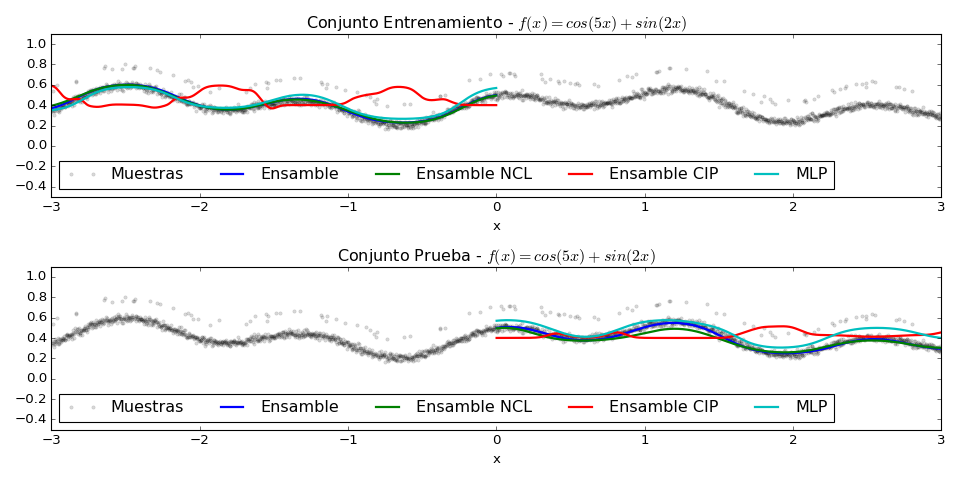

In [33]:
fig = plt.figure(figsize=(12, 6), dpi=80)

t = X_train[:,0]
plt.subplot(211)
plt.plot(x0, z, 'k.', alpha=0.15,  label='Muestras')
plt.plot(t, ensemble.predict(X_train), lw=2, label='Ensamble')
plt.plot(t, ensembleNCL.predict(X_train), lw=2, label='Ensamble NCL')
plt.plot(t, ensembleCIP.predict(X_train), lw=2, label='Ensamble CIP')
plt.plot(t, mlp.predict(X_train), lw=2, label='MLP')
plt.title('Conjunto Entrenamiento - %s' % fx_str)
plt.xlabel('x')
plt.xlim([-3,3])
plt.ylim([-0.5,1.1])
plt.legend(loc='best', ncol=5)


t = X_test[:,0]
plt.subplot(212)
plt.plot(x0, z, 'k.', alpha=0.15, label='Muestras')
plt.plot(t, ensemble.predict(X_test), lw=2, label='Ensamble')
plt.plot(t, ensembleNCL.predict(X_test), lw=2, label='Ensamble NCL')
plt.plot(t, ensembleCIP.predict(X_test), lw=2, label='Ensamble CIP')
plt.plot(t, mlp.predict(X_test), lw=2, label='MLP')
plt.title('Conjunto Prueba - %s' % fx_str)
plt.xlabel('x')
plt.xlim([-3,3])
plt.ylim([-0.5,1.1])
plt.legend(loc='best', ncol=5)

plt.tight_layout()

<IPython.core.display.Javascript object>


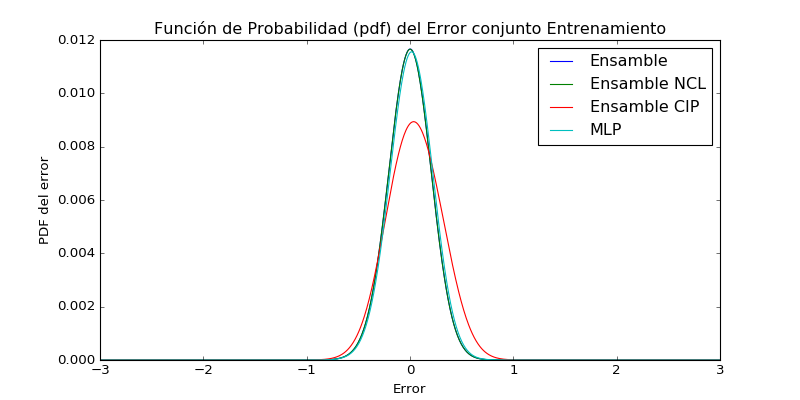

In [34]:
from sklearn.neighbors.kde import KernelDensity

def plot_pdf_error(pred, target, label_plot, ax, fig, n_points=1000, xmin=-3, xmax=3):
    error = pred - target
    N = len(error)
    s = 1.06 * np.std(error) / np.power(N, 0.2)  # Silverman
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde.fit(error)
    x_plot = np.linspace(xmin, xmax, n_points)[:, np.newaxis]
    y_plot = np.exp(kde.score_samples(x_plot))
    ax.plot(x_plot, y_plot / np.sum(y_plot), label=label_plot)
    
fig = plt.figure(figsize=(10, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_train), y_train, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_train), y_train, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleCIP.predict(X_train), y_train, 'Ensamble CIP', ax, fig)
plot_pdf_error(mlp.predict(X_train), y_train, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()

<IPython.core.display.Javascript object>


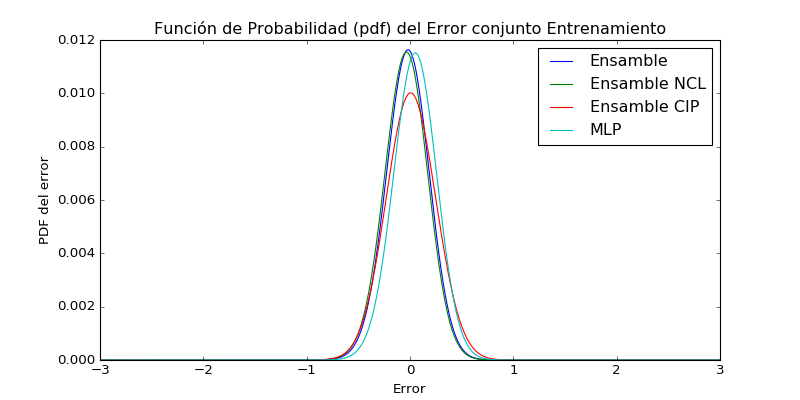

In [35]:
fig = plt.figure(figsize=(10, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_test), y_test, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_test), y_test, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleCIP.predict(X_test), y_test, 'Ensamble CIP', ax, fig)
plot_pdf_error(mlp.predict(X_test), y_test, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()

In [36]:
score_test_ensemble = ensemble.score(X_test, y_test)
score_train_ensemble = ensemble.score(X_train, y_train)

score_test_ensembleNCL = ensembleNCL.score(X_test, y_test)
score_train_ensembleNCL = ensembleNCL.score(X_train, y_train)

score_test_ensembleCIP = ensembleCIP.score(X_test, y_test)
score_train_ensembleCIP = ensembleCIP.score(X_train, y_train)

score_test_mlp = mlp.score(X_test, y_test)
score_train_mlp = mlp.score(X_train, y_train)

print('Score RMS')
print('Ensamble: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble KLG: %f / %f' % (score_train_ensembleCIP, score_test_ensembleCIP))
print('MLP: %f / %f' % (score_train_mlp, score_test_mlp))

Score RMS
Ensamble: 0.002540 / 0.003310
Ensamble NCL: 0.002599 / 0.004875
Ensamble KLG: 0.030769 / 0.017126
MLP: 0.003432 / 0.005831
